# EE512-project    
## Class Project1   Options Pricing via Monte Carlo Estimation
### Huihan Gao 4106-6450-95

In [16]:
import numpy as np

In [19]:
def generate_GBM(S0,T,mu,sigma):
    path = np.zeros(T)   #生成一个长度为T，每个数字都为0的数组
    path[0] = S0  #初始值为100
    dt = 1/365 
    rand=np.random.normal(loc=0.0, scale=np.sqrt(dt), size=T)
    for i in range(1,T):
        path[i] =path[i-1] + mu * path[i-1] * dt  + sigma * path[i-1] * rand[i]   #另一种算法
    return path
#generate_GBM(100,500,0.05,0.2)


array([100.        , 112.03519116, 117.08386181, 115.16665759,
       120.38179388, 121.81690587, 131.58489621, 120.69568284,
       113.18498096, 107.85409406, 103.32923402, 104.29263391,
       110.3460653 , 108.72159982, 114.92527156, 117.15027797,
       103.75426078, 104.59826158, 110.62144328, 107.38344642,
       105.49999085, 107.50423122, 108.99496924, 105.92506883,
       107.31630793, 115.519825  , 117.92385303, 108.51187474,
       114.2236066 , 107.88431915, 113.45003441, 123.9415258 ,
       129.25669867, 139.7126911 , 128.83447535, 131.48698049,
       115.43937281, 114.78386426, 124.04630361, 131.9868442 ,
       140.07415588, 134.68727772, 149.48430277, 159.92074731,
       160.27138763, 166.7438757 , 155.21891416, 164.40235367,
       165.84611092, 160.29072184, 162.61647996, 161.64247738,
       161.05158411, 158.20950868, 155.38580919, 160.62789791,
       160.53712435, 164.32116187, 156.55668242, 145.3006345 ,
       149.06884918, 143.53986685, 148.91217121, 142.35

# (a) payoff for the call option

In [20]:
def payoff(path, K):
    return max(path[-1] - K, 0)
#max(path最后一位-K,0)

# (b)expected value of European call options

5 sets of GBM parameters:(0.0016,0.13),(0.0016,0.2),(0.0049,0.2),(0.01,0.4),(0.01,0.6) <br/>
assumptions: constant asset volatilities, no discounting

In [28]:
S0 = 100   #初始值100
K = 95
T = 500    #500天
N = 4000   #进行1000次模拟
mus = [0.03,0.05,0.05,0.1,0.1]  #随便设置的mu和sigma
sigmas = [0.2,0.2,0.3,0.3,0.4]
value = np.zeros([5,N])      
path = np.zeros((5,N,T))  #path[5,1000,500],参数5对，模拟1000次，每次模拟得到一个长度为500的GBM path
for j in range(5):
    for i in range(N):
        G1 = generate_GBM(S0,T,mus[j],sigmas[j])  
        path[j,i] = G1
        value[j,i] = payoff(path[j,i], K) #记载每次模拟的GBM path得到的payoff
exp_value=np.mean(value,axis=1)  #取payoff的平均值，得到不贴现的expected value
exp_value  #这一格运行时间有点长

array([14.65839508, 17.14742052, 21.72868139, 27.5378821 , 30.52087541])

In [39]:
Es = S0*np.exp((mus-np.multiply(sigmas,sigmas))*T/365)
Es  #置信区间相关，未完成

array([101.81071882,  98.63947691, 101.37928863, 101.37928863,
        92.10952933])

# (c) the discounted expected payoff for the option

In [23]:
r = 0.05
dis_values = exp_value / np.power(1+r/365,500)
dis_values

array([13.52962182, 15.67079639, 21.2239474 , 23.87471897, 27.94142124])

# (d) Asian call option

In [30]:
path0 = path[:,:,::-50]
S_ave = np.mean(path0,axis=2)
value2 = np.zeros([5,N])
for j in range(5):
    for i in range(N):
        value2[j,i] = payoff([S_ave[j,i]],K)
exp_value2 = np.mean(value2,axis=1)
exp_value2    #不计算折旧

array([10.31231242, 11.51229996, 14.24380594, 17.344523  , 19.16286451])

In [31]:
exp_value  #(b)中得到的exp_value

array([14.65839508, 17.14742052, 21.72868139, 27.5378821 , 30.52087541])

# (e) Jump-Diffusion

In [38]:
def generate_GBM_jump(S0,T,mu,sigma,lamda):
    path = np.zeros(T)   #生成一个长度为T，每个数字都为0的数组
    path[0] = S0  #初始值为100
    dt = 1/365 
    rand=np.random.normal(loc=0.0, scale=np.sqrt(dt), size=T)
    M = np.random.poisson(lam=(lamda*(dt)), size=T)
    for i in range(1,T):
        path[i] =path[i-1] + mu * path[i-1] * dt  + sigma * path[i-1] * rand[i] + M[i]   #另一种算法
    return path

In [39]:
S0 = 100   #初始值100
K = 95
T = 500    #500天
N = 4000   #进行1000次模拟
mus = [0.03,0.05,0.05,0.1,0.1]  #随便设置的mu和sigma
sigmas = [0.2,0.2,0.3,0.3,0.4]
lamda = 0.05
value = np.zeros([5,N])      
path = np.zeros((5,N,T))  #path[5,1000,500],参数5对，模拟1000次，每次模拟得到一个长度为500的GBM path
for j in range(5):
    for i in range(N):
        G1 = generate_GBM_jump(S0,T,mus[j],sigmas[j],lamda)  
        path[j,i] = G1
        value[j,i] = payoff(path[j,i], K) #记载每次模拟的GBM path得到的payoff
exp_value=np.mean(value,axis=1)  #取payoff的平均值，得到不贴现的expected value
exp_value  #这一格运行时间有点长

array([14.84249062, 16.98703395, 20.54926518, 26.82362456, 30.71223169])

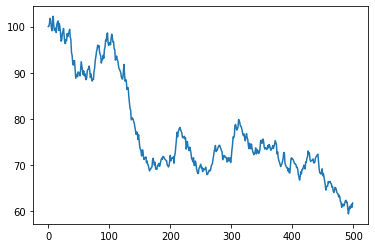

In [40]:
import matplotlib.pyplot as plt
plt.plot(path[1,1])